In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
from data_utils import balanced_supersample, balanced_subsample
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR * 5)
overlap = int(0)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        folds=10,
                        random_state=42
                       )

In [6]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
count,11821.000000,11821.000000,11821.000000,11821.000000,11821.000000,11821.000000,11821.000000,11821.000000,11821.000000,11821.000000,...,1.182100e+04,1.182100e+04,11821.000000,11821.000000,11821.000000,11821.000000,11821.000000,11821.000000,11821.000000,11821.000000
mean,28.655993,19.115341,14.227390,11.949877,9.835844,9.485634,9.144273,8.894551,8.779789,8.439329,...,-3.430151e-02,-3.480754e-02,39.789906,52.707741,14.162071,48.103849,1.331862,0.617207,23.399459,5.348109
std,23.411618,13.656164,11.803839,10.163034,9.572741,9.674578,9.534682,9.698703,9.685500,9.489621,...,4.418579e-02,4.282807e-02,316.353855,239.750324,75.572695,59.199809,2.764976,0.486089,12.876433,2.862094
min,0.003811,0.013764,0.005745,0.011357,0.007654,0.009210,0.006036,0.009025,0.001769,0.007476,...,-1.793470e-01,-1.797861e-01,4.879249,8.290693,1.165339,0.000000,0.145732,0.000000,0.000000,1.000000
25%,15.531070,11.377153,8.803277,6.962515,4.825166,4.336050,3.955340,3.649764,3.462431,3.154143,...,-6.804675e-02,-6.828210e-02,18.763330,27.808440,5.240043,25.765270,0.429783,0.000000,13.000000,3.000000
50%,23.440442,15.822490,11.278696,9.869603,8.932998,8.795495,8.634122,8.495180,8.404820,8.270358,...,-2.485263e-02,-2.576368e-02,26.584151,37.367031,9.239617,36.424840,0.618482,1.000000,25.000000,5.000000
75%,32.353484,21.465882,14.819164,12.330436,10.110731,9.861040,9.657267,9.398852,9.347884,9.119362,...,1.835141e-10,2.154175e-11,38.178672,51.800105,14.037533,54.294063,1.142522,1.000000,32.000000,8.000000
max,202.348903,113.774744,93.795679,78.764452,75.227919,79.348655,83.762159,96.108132,107.393085,105.205714,...,1.246974e-01,1.211130e-01,29973.855098,14851.131616,5582.087388,1913.831257,78.533247,1.000000,49.000000,10.000000


In [7]:
df.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,22.730479,11.520539,12.253581,10.212196,9.030011,8.739443,9.150218,8.880555,8.452500,8.334573,...,-0.166683,-0.098328,26.219456,48.082157,12.366428,38.334700,0.507233,0,0,6
1,64.003793,80.795260,48.198139,45.147334,52.268596,61.620040,67.565491,56.829182,58.988494,52.193907,...,0.036883,-0.030368,14.956899,16.258644,4.879466,20.019389,6.365389,0,14,9
2,91.373566,61.690092,58.582459,47.228346,47.274736,46.426917,43.962362,41.420272,40.828519,42.701780,...,-0.033933,0.042031,10.628136,20.016415,4.389970,15.713339,3.355069,1,36,3
3,76.457328,61.713594,55.535733,45.361320,44.202866,45.188370,41.861242,40.734830,42.070456,45.359905,...,0.004314,-0.000106,11.680668,22.676710,4.365168,18.374868,4.289678,1,36,6
4,78.146667,61.344895,75.063524,45.483954,44.813375,43.982927,41.635170,38.359653,39.252493,40.490933,...,0.026272,-0.014902,12.457344,17.988716,2.949997,18.285330,3.344113,1,19,8


In [8]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [9]:
X = (df[df.fold != 1]).drop(['target', 'h_target', 'fold'], axis=1)
y = (df[df.fold != 1])['h_target']

In [10]:
X, y = balanced_supersample(X, y)

# Training

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import scipy

params = {
    'classify__n_estimators': range(5,100,1),
    'classify__criterion': ('gini', 'entropy'),
    'classify__max_depth': range(len(df.columns), 5 * len(df.columns)),
    'classify__max_features': ('log2', 'auto', None),
    'classify__oob_score': (True, False),
    'classify__warm_start': (True, False)
}

clf = Pipeline([
    ('scaler',MinMaxScaler()),
    ('classify', RandomForestClassifier(n_jobs=-1, random_state=42))
])
randsrc = RandomizedSearchCV(
                clf,
                scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'], 
                cv=10,
                refit=False,
                param_distributions = params,
                verbose=2,
                n_jobs=-1,
                n_iter=100
)

randsrc.fit(X, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 18.6min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,...ors='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'classify__max_depth': range(132, 660), 'classify__criterion': ('gini', 'entropy'), 'classify__warm_start': (True, False), 'classify__n_estimators': range(5, 100), 'classify__oob_score': (True, False), 'classify__max_features': ('log2', 'auto', None)},
          pre_dispatch='2*n_jobs', random_state=None, refit=False,
          return_train_score='warn',
          scoring=['accuracy', 'f1', 'recall', 'precision', 'roc_auc'],
    

In [12]:
results = pd.DataFrame(randsrc.cv_results_)

In [13]:
top = results.sort_values(['mean_test_roc_auc', 'mean_fit_time'], ascending=[False, True]).iloc[0]

In [14]:
top.params

{'classify__criterion': 'entropy',
 'classify__max_depth': 185,
 'classify__max_features': 'auto',
 'classify__n_estimators': 97,
 'classify__oob_score': True,
 'classify__warm_start': True}

In [15]:
clf.set_params(**top.params)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=185, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=97, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=True))])

# Testing Optimal Classifier

### Training

In [16]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [17]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
train_X, train_y = balanced_supersample(train_X, train_y)
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']

In [18]:
clf.fit(train_X, train_y)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=185, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=97, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=True))])

0.7209414024975984
Confusion matrix, without normalization
[[ 465  310]
 [ 271 1036]]


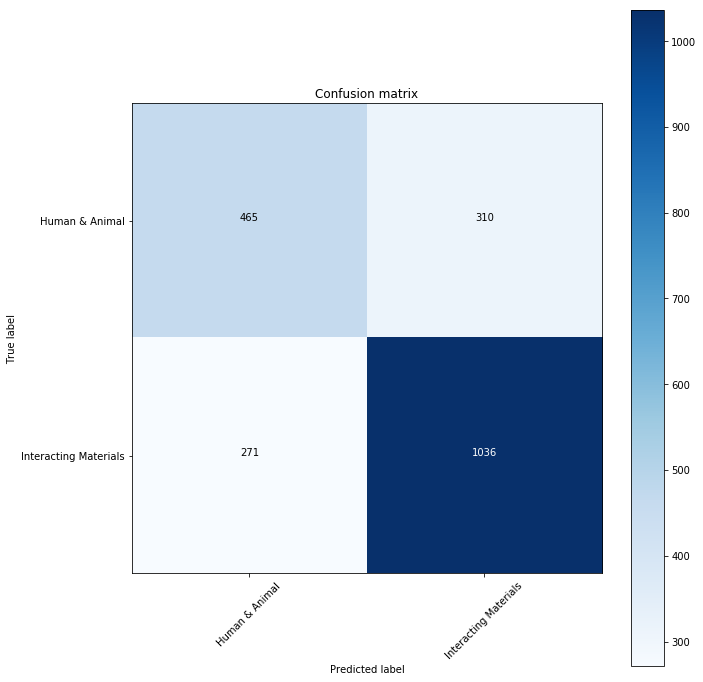

In [19]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

### Testing

In [20]:
all_df = df[df.fold == 1]

In [21]:
X = all_df.drop(['target', 'h_target', 'fold'], axis=1)
y = all_df['h_target']

0.6413890857547838
Confusion matrix, without normalization
[[234 277]
 [229 671]]


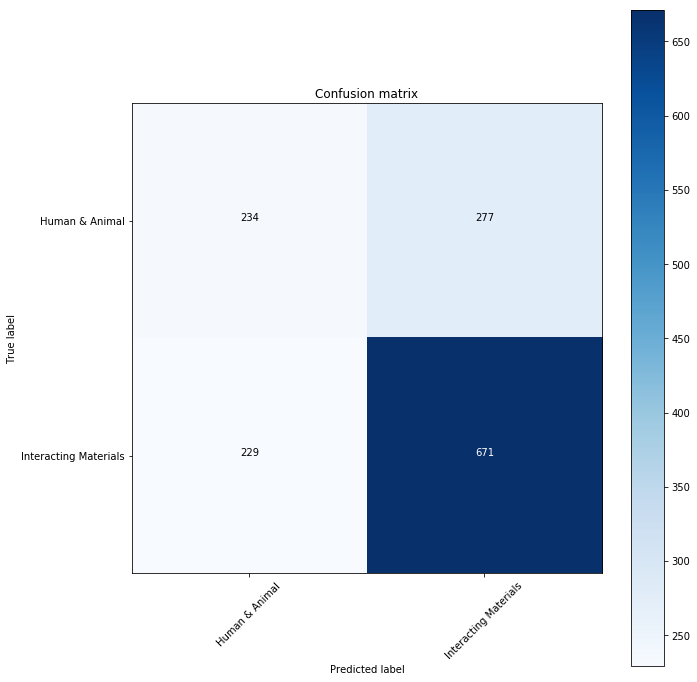

In [22]:
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

### Confidence

In [23]:
import seaborn as sns
misclassified = {
    'Predicted h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}
for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Actual target'].append(classes[int(row[1]['target'])])
        misclassified['Predicted h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,Actual target,Anim_prob,Interact_prob,Predicted h_target
0,sheep,0.412371,0.587629,Interacting Materials
1,sheep,0.298969,0.701031,Interacting Materials
2,sheep,0.463918,0.536082,Interacting Materials
3,sheep,0.402062,0.597938,Interacting Materials
4,sheep,0.484536,0.515464,Interacting Materials


In [24]:
gb_ms = misclassified.groupby('Predicted h_target')
means = gb_ms.mean()
errors = gb_ms.std()

In [25]:
means.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.600459,0.399541
Interacting Materials,0.347091,0.652909


In [26]:
errors.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.072075,0.072075
Interacting Materials,0.123480,0.123480


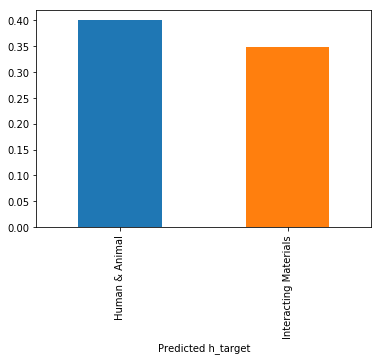

In [27]:
means.min(axis=1).plot(yerr=errors, kind='bar')

In [28]:
average_prob = misclassified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob
Actual target,,
breathing,0.418099,0.581901
brushing_teeth,0.607181,0.392819
can_opening,0.539519,0.460481
car_horn,0.597938,0.402062
cat,0.402062,0.597938
chirping_birds,0.335052,0.664948
clapping,0.630339,0.369661
clock_tick,0.608247,0.391753
coughing,0.476804,0.523196


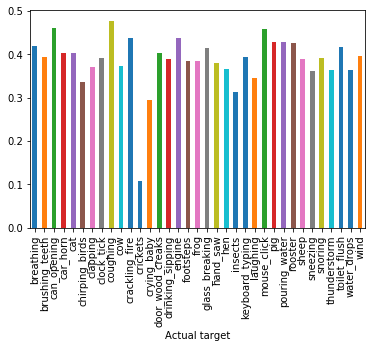

In [29]:
average_prob.min(axis=1).plot(kind='bar')

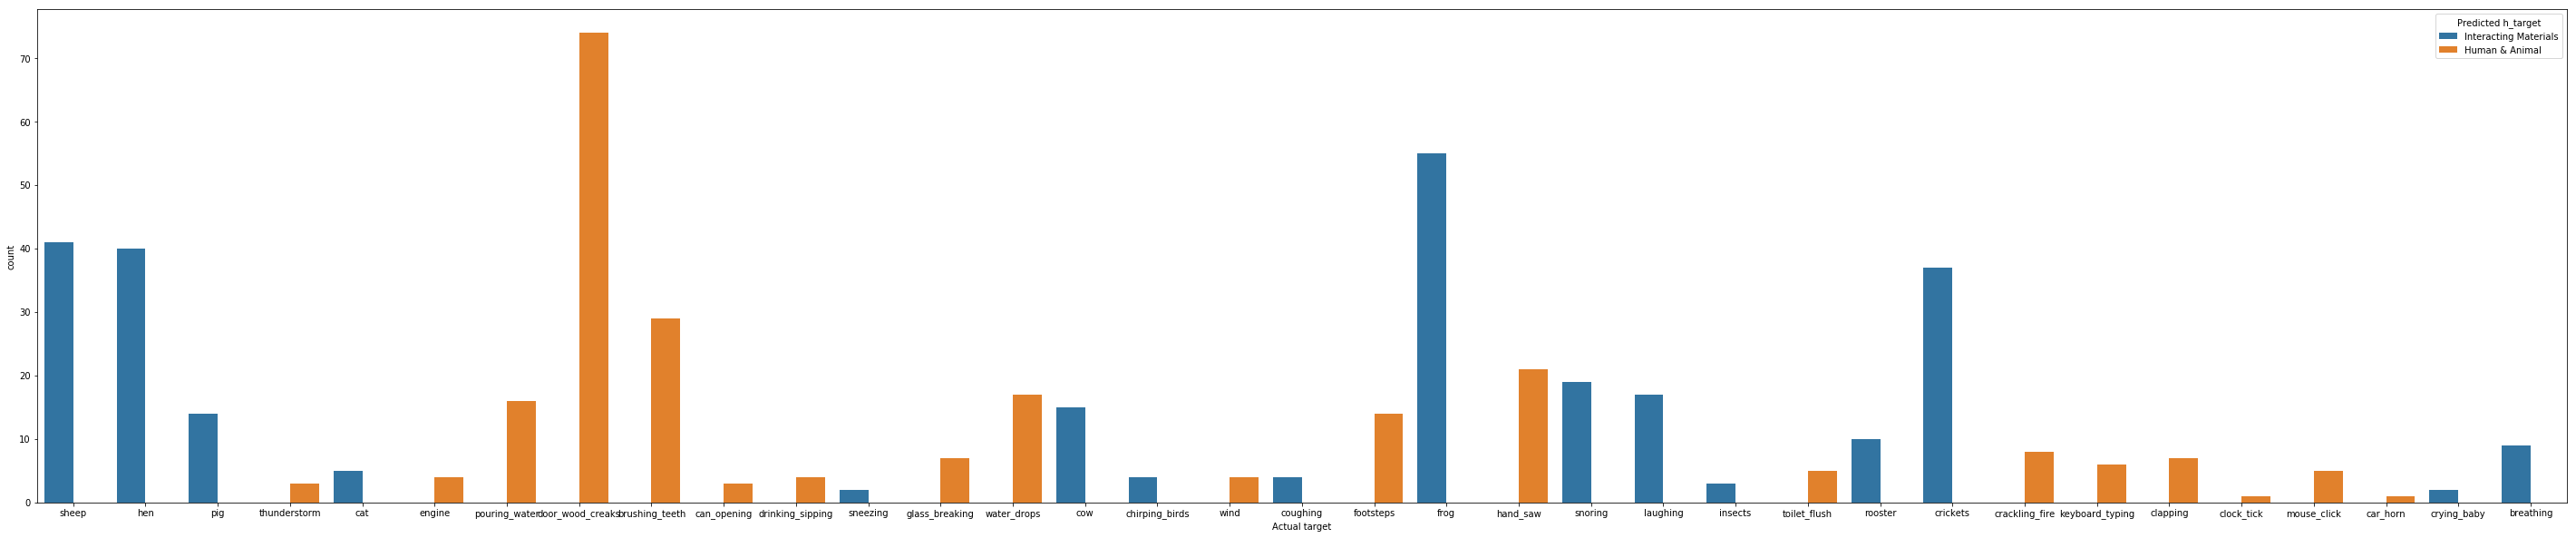

In [30]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='Actual target', hue='Predicted h_target',data=misclassified)